In [121]:
# do required imports
import difflib
import torch
from torch.autograd import Variable
import torch.nn as nn
import pickle
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(2834)
import matplotlib.ticker as mtick
import matplotlib as matplotlib
matplotlib.rcParams.update({'font.size': 12})
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [3]:
lm = torch.load('model.pt', map_location=lambda storage, loc: storage)

In [4]:
# Load dictionary word --> id 
dictionary = pickle.load(open('dict', 'rb'))

# set the maximum sequence length
max_seq_len = 50

# function to transform sentence into word id's and put them in a pytorch Variable
# NB Assumes the sentence is already tokenised!
def tokenise(sentence, dictionary):
    words = sentence.split(' ')
    l = len(words)
    assert l <= max_seq_len, "sentence too long"
    token = 0
    ids = torch.LongTensor(l)

    for word in words:
        try:
            ids[token] = dictionary.word2idx[word]
        except KeyError:
            print( word)
            raw_input()
            ids[token] = dictionary.word2idx['<unk>']
        token += 1
    return ids

In [5]:
# load pytorch softmax function
softmax = nn.Softmax()

def evaluate(model, dictionary, sentence, check_words):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    
    # number of tokens (= output size)
    ntokens = len(dictionary)
    hidden = model.init_hidden(1)
    
    # tokenise the sentence, put in torch Variable
    test_data = tokenise(sentence, dictionary)
    input_data = Variable(test_data, volatile=True)

    # run the model, compute probabilities by applying softmax
    output, hidden = model(input_data, hidden)
    output_flat = output.view(-1, ntokens)
    logits = output[-1, :]
    sm = softmax(logits).view(ntokens)
    
    # get probabilities of certain words by looking up their
    # indices and print them
    def get_prob(word):
        return sm[dictionary.word2idx[word]].data[0]

    #print (sentence, '\n')
    #print ('\n'.join(
    #        ['%s: %f' % (word, get_prob(word)) for word in check_words]
    #        ) )
    return  [{word : get_prob(word)} for word in check_words]

In [6]:
# Compose sentence prefixes with frequent words.
# The sentence prefixes are intended to test intervening nouns.


NN = ['company', 'year', 'market', 'share', 'stock', 'system', 'president', 'business', 
      'quarter', 'government', 'time', 'week', 'price', 'group', 'interest',
      'industry', 'unit','month', 'rate', 'investment', 'state', 'producer', 'income', 
      'program', 'bank', 'part', 'plan', 'sale', 'issue', 'tax', 'way', 'loss', 'executive', 'day', 'bid', 'data', 'line','hour', 'plant', 'concern']

NNS = ['companies', 'years', 'markets', 'shares', 'stocks', 'systems', 'presidents', 
       'businesses', 'quarters', 'governments', 'times', 'weeks', 'prices', 'groups', 'interests', 'industries', 
       'units', 'months', 'rates', 'investments', 'states', 'producers', 'incomes', 'programs', 'banks', 'parts', 'plans', 
      'sales', 'issues', 'taxes', 'ways', 'losses', 'executives', 'days', 'bids', 'data', 'lines', 'hours', 'plants', 'concerns',]

VBP = ['are', 'have', 'do', 'say', 'think', 'want', 'expect', 'include', 'ask', 
       'make', 'need', 'know', 'see', 'get', 'seem', 'remain', 'continue', 'show', 'buy', 
       'feel', 'go', 'sell', 'take', 'use', 'plan', 'look', 'tend', 'hope', 'argue', 'give',
       'pay', 'appear', 'suggest', 'fear', 'find', 'come', 'offer', 'contend', 'agree', 'provide']

VBZ = ['is', 'has', 'does', 'says', 'thinks', 'wants', 'expects', 'includes', 'asks', 'makes',
      'needs', 'knows', 'sees', 'gets', 'seems', 'remains', 'continues', 'shows', 'buys', 'feels', 'goes', 'sells',
      'takes', 'uses', 'plans', 'looks', 'tends', 'hopes', 'argues', 'gives', 'pays', 'appears', 'suggests', 'fears',
      'finds', 'comes', 'offers', 'contends', 'agrees', 'provides']

attractor_helpers = ['in the', 'by the', 'close to the', 'of the', 'at the', 'and not the', 'without']



In [7]:
def calculate_error_rate(sentences):
    result = calculate_errors(sentences)
    #print(result)
    return 1- sum(result)/len(result)
    
def calculate_errors(sentences):
    return [calculate_error(s) for s in sentences]

def calculate_error(sentence):
    return 1 if is_correct_prediction(sentence[0], sentence[1], sentence[2]) else 0 

def is_correct_prediction(sentence, check_words, correct_word):
    predictions = evaluate(lm, dictionary, sentence, check_words)
    words,preds = zip(*list(map(lambda x: list(x.items())[0],predictions)))
    predicted_word = words[np.argmax(preds)]
    return predicted_word == correct_word

In [8]:
# Compose sentence prefixes with frequent words with one and without attractors

def gen_simple_case_matrix(NN, NNS, VBP, VBZ):
    assert(len(VBP) == len(VBZ))

    nouns = NN + NNS
    noun_count = len(nouns)
    verb_count = len(VBP)
    result = []
    for index_noun in range(noun_count):
        row = []
        for index_verb in range(verb_count):
            correct = VBZ[index_verb] if index_noun < len(NN) else VBP[index_verb]
            sentence = (f"the {nouns[index_noun]}", [VBP[index_verb], VBZ[index_verb]], correct)
            #row.append(sentence)
            row.append(calculate_error(sentence))
        result.append(row)
    return result
            
            
    


In [11]:
# simple cases: nouns x verbs results, 0 = error, 1 = correct
# first half of the rows are singular nouns,
# second half are plural nouns
n = 30 

noun_verb_matrix = np.array(gen_simple_case_matrix(NN[0:n], NNS[0:n], VBP[0:n], VBZ[0:n]))

In [139]:

# Todo sort columns and rows and make sense of it (by looking at frequencies)
# split in NN and NNS
matrix_NN = noun_verb_matrix[:n]
matrix_NNS = np.array(noun_verb_matrix[n:]

In [146]:
# sort after col
matrix_NN_sorted_idx_col = np.argsort(matrix_NN.sum(axis=0))
matrix_NN_sorted_col = matrix_NN[:, matrix_NN_sorted_idx_col]
matrix_NNS_sorted_idx_col = np.argsort(matrix_NNS.sum(axis=0))
matrix_NNS_sorted_col = matrix_NNS[:, matrix_NNS_sorted_idx_col]
# sort after row
matrix_NN_sorted_idx_row = np.argsort(matrix_NN_sorted_col.sum(axis=1))
matrix_NN_sorted_row = matrix_NN_sorted_col[matrix_NN_sorted_idx_row,:]
matrix_NNS_sorted_idx_row = np.argsort(-matrix_NNS_sorted_col.sum(axis=1))
matrix_NNS_sorted_row = matrix_NNS_sorted_col[matrix_NNS_sorted_idx_row,:]
#concatenate matrices
matrix = np.concatenate((matrix_NN_sorted_row,matrix_NNS_sorted_row),axis=0)

(60, 30)


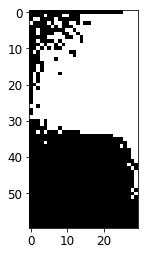

In [147]:
print(matrix.shape)
plt.imshow(matrix, cmap=cm.gray)
plt.show()
plt.imsave('matrix_plot.png',matrix, cmap=cm.gray)

In [ ]:
# Change the sort order for the upper half of the figure

In [ ]:
# IDEA: 
# Color code verb plurality ratios, i.e. Count(produce)/Count(produces)
# and print below diagram as some sort of 'x-axis'
# Color code noun counts, i.e. Count(company)
# and print at the left of the diagram as some sort of 'y-axis'

In [ ]:
# IDEA: 
# Create the same diagram for the infrequent nouns. 
# Presumably they are more likely to follow verb preferences, can we see that in the shape?

# Try also to sort the colomns using the column sorting indexes as in the figure above 
# (instead of using the sum criterion).
# Presumably the verbs have the same preferences, can we see that in the shape?


In [1]:
# IDEA:
# The model outputs probabilities. Instead of just printing black and white it may be interested to
# indicate the uncertainty of the model in grey teints
# p-verb = p-plural + p-singular, colorcode = p-plural/p-verb